In [1]:
import pickle
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from tqdm import tqdm
from gc import collect


pd.options.mode.chained_assignment = None

In [2]:
full = pd.read_csv('training_set_VU_DM.csv', parse_dates=['date_time'])
# df = full.sample(frac=0.01)
# df.head()

In [3]:
fillna = dict( # Different values to replace NaNs in each column
    visitor_hist_starrating = -1,
    visitor_hist_adr_usd = -1,
    prop_review_score = -1,
    prop_location_score2 = -1,
    srch_query_affinity_score = -1,
    orig_destination_distance = -1,
    **{f"comp{i}_rate": 0 for i in range(1, 9)},
    **{f"comp{i}_inv": -1 for i in range(1, 9)},
    **{f"comp{i}_rate_percent_diff": -1 for i in range(1, 9)}
)
missing = {f"comp{i}_rate_missing": f"comp{i}_rate" for i in range(1, 9)}

In [4]:
# Add additional columns where filling in NaNs with special values isn't enough
def fillnans(df):
    for k, v in missing.items():
        df[k] = df[v].isna().astype(int)
    return df.fillna(fillna)

In [5]:
def split_time(df):
    # Split date_time into year, month, day, and time
    dates = np.vstack(df.date_time.dt.strftime("%Y,%m,%d,%H,%M,%S").str.split(',').map(np.asarray)).astype(int)
    dates[:,0] -= 2000 # Years before 2000 are negative
    df[['year', 'month', 'day']] = dates[:,:3]
    df['time'] = (dates[:,3] * 3600 + dates[:,4] * 60 + dates[:,5]) / 86400 # Time in range 0 to 1
    return df.drop(columns='date_time')

In [6]:
def clean(df):
    df = df[~(df.price_usd > df.price_usd.mean() + 3 * df.price_usd.std())] # Drop outliers
    return df[df.price_usd != 0] # Drop instances where the property costs nothing

In [7]:
full = clean(split_time(fillnans(full)))
full = full.reset_index()

In [8]:
enc = np.load('enc.npy')
pca = pickle.load(open("pca.pkl", 'rb'))

In [ ]:
full = full.drop(columns=['site_id', 'visitor_location_country_id', 'prop_country_id'])

# One-hot encode categorical values
def encode(df):
    # Reduce the size of the one-hot encoded variables with PCA
    return pd.concat([df, pd.DataFrame(pca.transform(enc[df.index]), index=df.index)], axis=1)

In [17]:
def split_data_and_targets(df):
    metadata = df[['srch_id', 'prop_id', 'position', 'gross_bookings_usd', 'click_bool', 'booking_bool']]
    metadata.loc[:, 'booking_bool'] *= 5
    metadata.loc[:, 'target'] = metadata.iloc[:,-2:].max(axis=1)
    return (
        df.drop(columns=['srch_id', 'position', 'click_bool', 'booking_bool', 'gross_bookings_usd']),
        metadata
    )

In [18]:
def pipeline(df, ret='torch'):
    df = encode(df)
    df, metadata = split_data_and_targets(df)
    if ret != 'torch':
        return df, metadata
    return (
        torch.tensor(df.to_numpy(), dtype=torch.float32, device='cuda'),
        torch.tensor(metadata.target.to_numpy(), dtype=torch.float32, device='cuda').reshape(-1, 1)
    )

In [23]:
net = nn.Sequential(
    nn.BatchNorm1d(221),
    nn.Linear(221, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 2048),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1)
).to('cuda')

criterion = nn.MSELoss()
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=3e-4, weight_decay=1e-4)

In [ ]:
def train(model, opt, data, targets, bs=1024):
    losses = list()
    for i in tqdm(range(0, len(data), bs)):
        x, y = data[i:i+bs], targets[i:i+bs]
        opt.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        opt.step()
        losses.append(loss.detach().cpu())
    return losses

In [25]:
EPOCHS = 5
bs = 1024

losses = list()
for i in range(EPOCHS):
    net.train
    train(lambda x: nn.functional.sigmoid(net(x)) * 5, optimizer, *pipeline(full.sample(frac=0.1)), bs=bs)

100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:07<00:00, 61.82it/s]


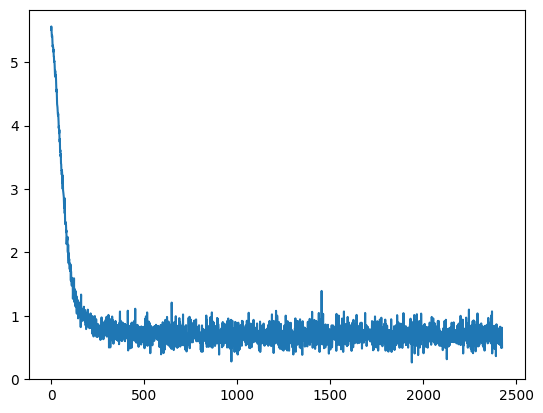

In [26]:
plt.plot(losses)

In [158]:
class ResNet(nn.Module):
    def __init__(self, inp, hidden=1024):
        super().__init__()
        self.inp = inp
        self.hidden = hidden
        self.bn1 = nn.BatchNorm1d(inp)
        self.lin1 = nn.Linear(inp, hidden)
        self.lin2 = nn.Linear(2 * inp, hidden)
        self.lin3 = nn.Linear(2 * inp, hidden)
        self.lin4 = nn.Linear(2 * inp, hidden)
        self.lin5 = nn.Linear(inp, 1)
        self.relu = nn.ReLU()
        self.res1 = self.res_block()
        self.res2 = self.res_block()
        self.res3 = self.res_block()
        self.res4 = self.res_block()
    
    def res_block(self):
        return nn.Sequential(
            nn.BatchNorm1d(self.hidden),
            nn.Linear(self.hidden, 2 * self.hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2 * self.hidden, self.hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.hidden, self.hidden // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.hidden // 2, self.inp),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
    
    def forward(self, x):
        y = self.relu(self.lin1(self.bn1(x)))
        y = self.lin2(torch.hstack([self.res1(y), x]))
        y = self.lin3(torch.hstack([self.res2(y), x]))
        y = self.lin4(torch.hstack([self.res3(y), x]))
        y = self.lin5(self.res4(y))
        return nn.functional.sigmoid(y) * 5

In [161]:
net = ResNet(221).to('cuda')
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=3e-5, weight_decay=1e-4)

In [167]:
# losses = list()
for i in range(EPOCHS):
    net.train
    l = train(net, optimizer, *pipeline(full.sample(frac=0.1)), bs=bs)
    losses.extend(l)
    print(sum(losses)/len(losses))

100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [04:38<00:00,  1.74it/s]


tensor(0.7142)


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [04:38<00:00,  1.74it/s]


tensor(0.7131)


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [04:38<00:00,  1.74it/s]


tensor(0.7119)


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [04:38<00:00,  1.74it/s]


tensor(0.7108)


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [04:38<00:00,  1.74it/s]

tensor(0.7097)


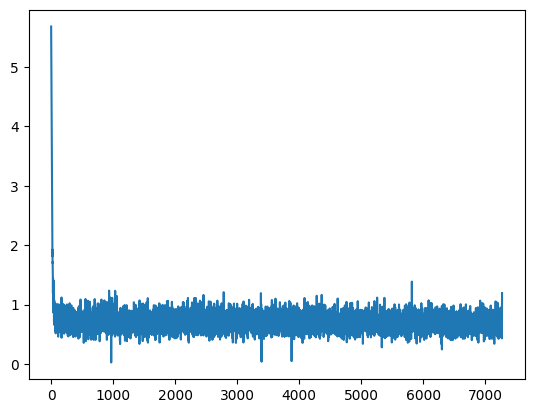

In [166]:
plt.plot(losses)

In [168]:
torch.save(net, 'ResNet.pt')